# Water Segmentation

## Data 

#### Lib

In [1]:
import os
import numpy as np
import cv2  # OpenCV for reading images
import imageio
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

#### Directory Paths

In [2]:
IMAGE_DIR = r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\images'  # Folder containing input images
LABEL_DIR = r'C:\Users\Test\Downloads\data-20250216T204641Z-001\data\labels'  # Folder containing binary masks


#### Parameters

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 12  # 12 Channels as per the provided image
BATCH_SIZE = 16
EPOCHS = 50

#### Function to Load and Preprocess Data

In [4]:
def load_data(image_dir, label_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        base_name = filename.split('.')[0]
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, base_name + '.png')
        image = imageio.imread(image_path)
        label = imageio.imread(label_path)
        
        # Resize images to (128, 128)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        label = cv2.resize(label, (IMG_WIDTH, IMG_HEIGHT))

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

#### Loading Data

In [5]:
X, Y = load_data(IMAGE_DIR, LABEL_DIR)
Y = np.expand_dims(Y, axis=-1)  # Adding channel dimension to labels (for binary segmentation)

C:\Users\Test\AppData\Local\Temp\ipykernel_3308\4013669067.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\Test\AppData\Local\Temp\ipykernel_3308\4013669067.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_path)


#### Normalization

In [6]:
X = X / 10000.0  # Normalizing reflectance bands

## Visualization

#### Visualization of Input Data (Band Visualization)

Each image in our dataset contains 12 spectral bands, each capturing different wavelengths of light. These bands provide unique insights into land and water features. For example, Near-Infrared (NIR) is great for detecting water, while Shortwave Infrared (SWIR) helps analyze soil moisture. By combining all 12 bands, our deep learning model can make highly accurate water body segmentation decisions.

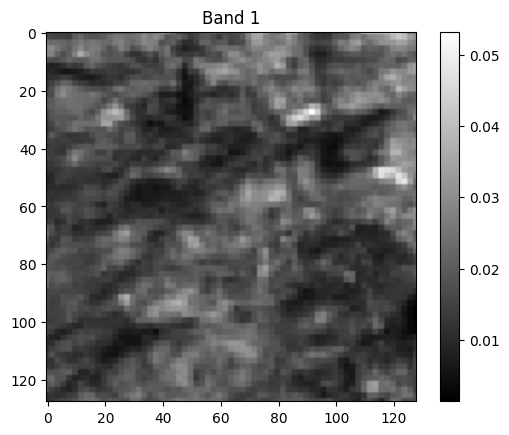

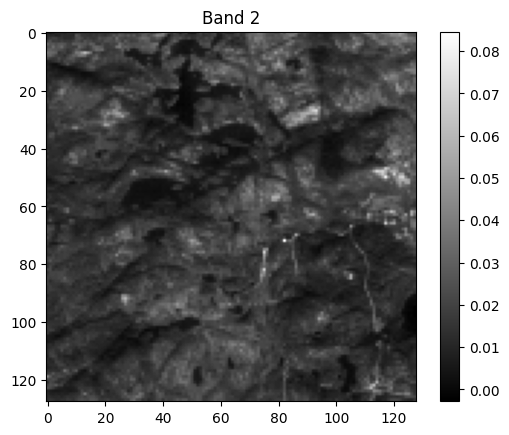

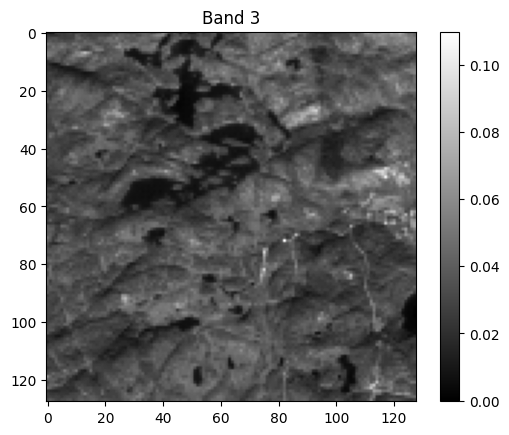

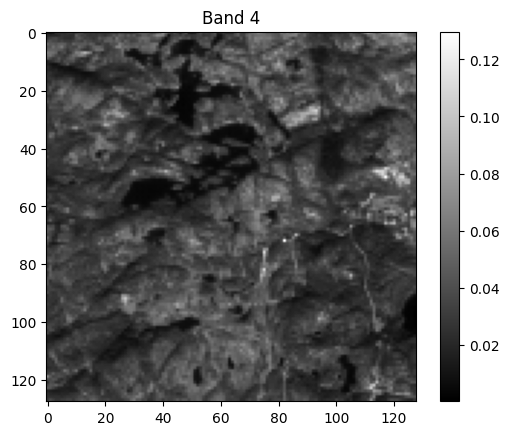

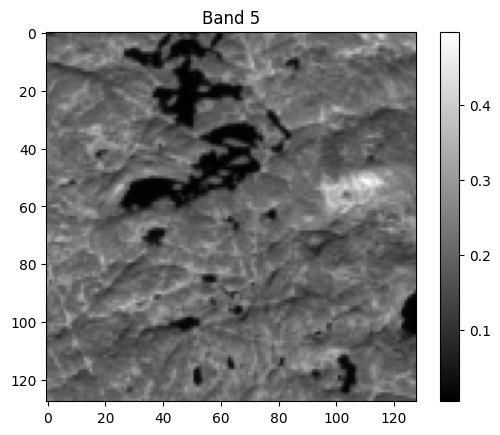

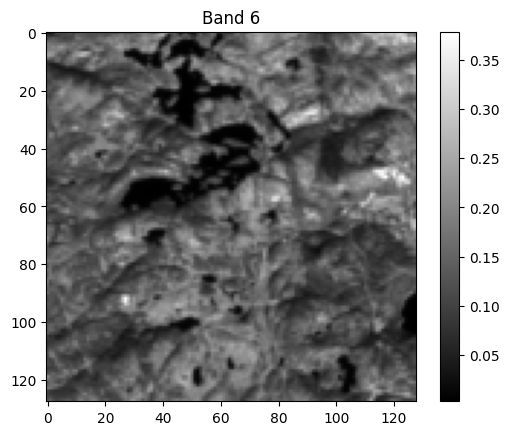

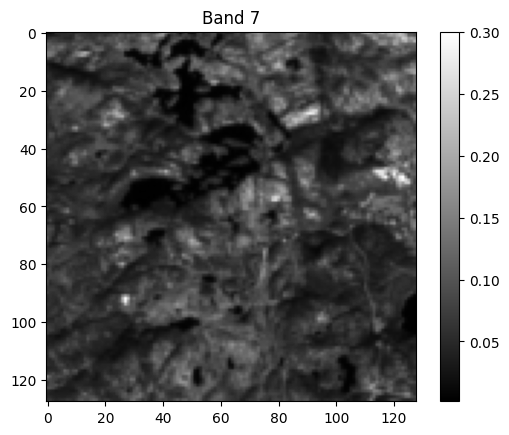

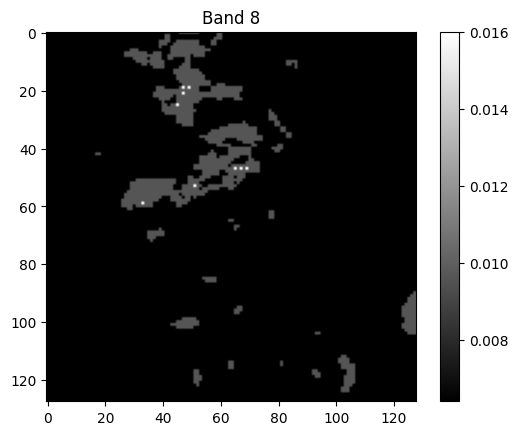

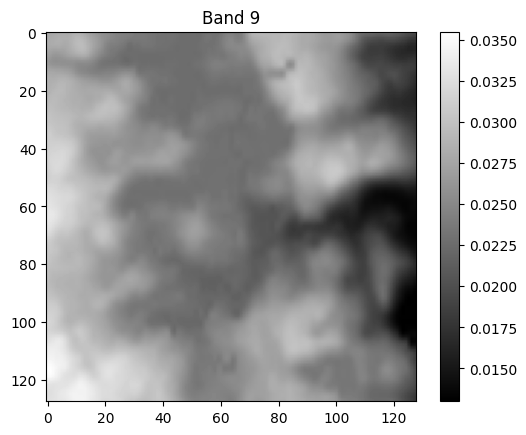

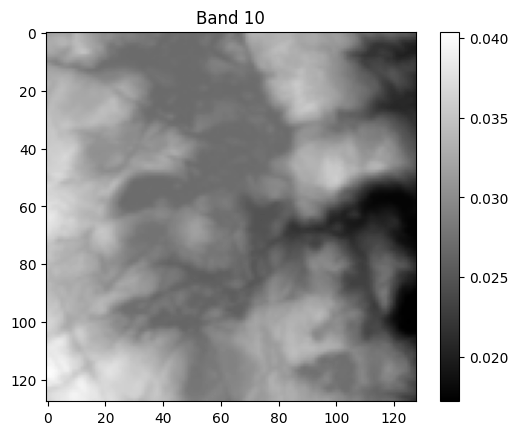

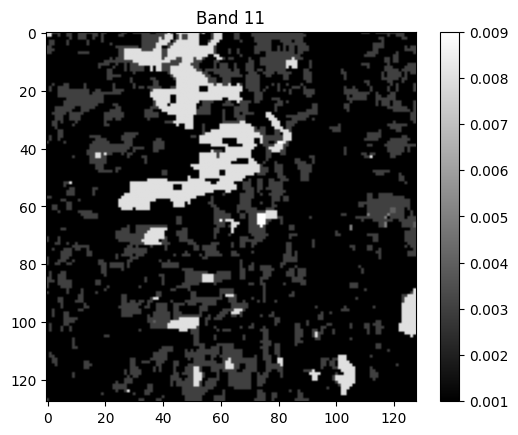

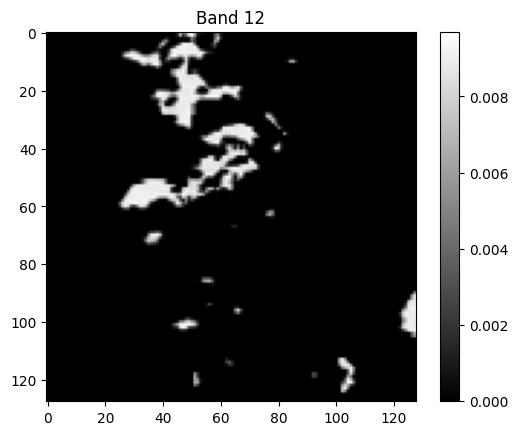

In [7]:
for i in range(IMG_CHANNELS):
    plt.figure()
    plt.title(f"Band {i+1}")
    plt.imshow(X[0, :, :, i], cmap='gray')
    plt.colorbar()
    plt.show()

## Model

#### Train-Validation Split

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

#### U-Net Model Definition

In [9]:
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

#### Compile the Model

In [10]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,488 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,762,689 (29.61 MB)

 Trainable params: 7,762,689 (29.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Callbacks

In [11]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#### Model Training

In [12]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


c:\Users\Test\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7262 - loss: 0.5806

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7265 - loss: 0.5772 - val_accuracy: 0.7756 - val_loss: 0.3777
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8145 - loss: 0.3788

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8158 - loss: 0.3795 - val_accuracy: 0.8999 - val_loss: 0.3119
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8857 - loss: 0.3452

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8861 - loss: 0.3433 - val_accuracy: 0.9112 - val_loss: 0.2622
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8979 - loss: 0.2964

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8981 - loss: 0.2959 - val_accuracy: 0.9143 - val_loss: 0.2532
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9018 - loss: 0.2799

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9019 - loss: 0.2796 - val_accuracy: 0.9142 - val_loss: 0.2429
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8957 - loss: 0.2835 - val_accuracy: 0.9147 - val_loss: 0.2450
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9016 - loss: 0.2747

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9018 - loss: 0.2744 - val_accuracy: 0.9156 - val_loss: 0.2377
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9127 - loss: 0.2548

16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9123 - loss: 0.2552 - val_accuracy: 0.9128 - val_loss: 0.2300
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9129 - loss: 0.2489 - val_accuracy: 0.9147 - val_loss: 0.2309
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9076 - loss: 0.2576

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9075 - loss: 0.2576 - val_accuracy: 0.9125 - val_loss: 0.2287
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9177 - loss: 0.2336

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9171 - loss: 0.2349 - val_accuracy: 0.9141 - val_loss: 0.2269
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9086 - loss: 0.2541

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9085 - loss: 0.2542 - val_accuracy: 0.9167 - val_loss: 0.2239
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9069 - loss: 0.2521

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9069 - loss: 0.2520 - val_accuracy: 0.9161 - val_loss: 0.2175
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9034 - loss: 0.2548 - val_accuracy: 0.9182 - val_loss: 0.2275
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9117 - loss: 0.2427

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9114 - loss: 0.2431 - val_accuracy: 0.9184 - val_loss: 0.2130
Epoch 16/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9049 - loss: 0.2530

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9051 - loss: 0.2523 - val_accuracy: 0.9183 - val_loss: 0.2099
Epoch 17/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9114 - loss: 0.2354 - val_accuracy: 0.9189 - val_loss: 0.2128
Epoch 18/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9054 - loss: 0.2509 - val_accuracy: 0.9162 - val_loss: 0.2145
Epoch 19/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9111 - loss: 0.2397 - val_accuracy: 0.9143 - val_loss: 0.2198
Epoch 20/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9066 - loss: 0.2493 - val_accuracy: 0.9198 - val_loss: 0.2124
Epoch 21/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9122 - loss: 0.2382

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9120 - loss: 0.2381 - val_accuracy: 0.9153 - val_loss: 0.2089
Epoch 22/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9009 - loss: 0.2447 - val_accuracy: 0.9172 - val_loss: 0.2098
Epoch 23/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9186 - loss: 0.2194

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9181 - loss: 0.2204 - val_accuracy: 0.9199 - val_loss: 0.2049
Epoch 24/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9105 - loss: 0.2413 - val_accuracy: 0.9200 - val_loss: 0.2100
Epoch 25/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9202 - loss: 0.2091

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9195 - loss: 0.2104 - val_accuracy: 0.9205 - val_loss: 0.2044
Epoch 26/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9130 - loss: 0.2336 - val_accuracy: 0.9152 - val_loss: 0.2117
Epoch 27/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9061 - loss: 0.2411 - val_accuracy: 0.9188 - val_loss: 0.2044
Epoch 28/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9041 - loss: 0.2437

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9046 - loss: 0.2429 - val_accuracy: 0.9210 - val_loss: 0.2024
Epoch 29/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9163 - loss: 0.2208

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9161 - loss: 0.2212 - val_accuracy: 0.9213 - val_loss: 0.2000
Epoch 30/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9153 - loss: 0.2191

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9151 - loss: 0.2194 - val_accuracy: 0.9201 - val_loss: 0.1961
Epoch 31/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9198 - loss: 0.2078

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9194 - loss: 0.2087 - val_accuracy: 0.9214 - val_loss: 0.1936
Epoch 32/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9088 - loss: 0.2318 - val_accuracy: 0.9208 - val_loss: 0.1969
Epoch 33/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9209 - loss: 0.2031 - val_accuracy: 0.9212 - val_loss: 0.1970
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9153 - loss: 0.2152 - val_accuracy: 0.9178 - val_loss: 0.1998
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9062 - loss: 0.2361 - val_accuracy: 0.9203 - val_loss: 0.1986
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9064 - loss: 0.2370 - val_accuracy: 0.9173 - val_loss: 0.2009
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9189 - loss: 0.2074 - val_accuracy: 0.9200 - val_loss: 0.1995
Epoch 38/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9189 - loss: 0.2107 - val_accuracy: 0.9212 - val_loss: 0.1

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9108 - loss: 0.2286 - val_accuracy: 0.9223 - val_loss: 0.1898
Epoch 42/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9175 - loss: 0.2068 - val_accuracy: 0.9224 - val_loss: 0.1905
Epoch 43/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9164 - loss: 0.2066 - val_accuracy: 0.9214 - val_loss: 0.1902
Epoch 44/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9072 - loss: 0.2223

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9075 - loss: 0.2219 - val_accuracy: 0.9213 - val_loss: 0.1885
Epoch 45/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9162 - loss: 0.2191 - val_accuracy: 0.9181 - val_loss: 0.1945
Epoch 46/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9141 - loss: 0.2166 - val_accuracy: 0.9230 - val_loss: 0.1888
Epoch 47/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9220 - loss: 0.2009 - val_accuracy: 0.9201 - val_loss: 0.1902
Epoch 48/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9216 - loss: 0.1970 - val_accuracy: 0.9091 - val_loss: 0.2351
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9099 - loss: 0.2485 - val_accuracy: 0.9172 - val_loss: 0.2002
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9070 - loss: 0.2294 - val_accuracy: 0.9218 - val_loss: 0.1982


#### Evaluation Metrics

In [13]:
def evaluate_model(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = (y_pred.flatten() > 0.5).astype(np.uint8)

    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)
    iou = jaccard_score(y_true_flat, y_pred_flat)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"IoU: {iou:.4f}")


#### Predict and Evaluate

In [14]:

y_pred = model.predict(X_val)
evaluate_model(Y_val, y_pred)

c:\Users\Test\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 128, 12))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Precision: 0.9382
Recall: 0.6949
F1-Score: 0.7984
IoU: 0.6645


#### Visualization of Training Results

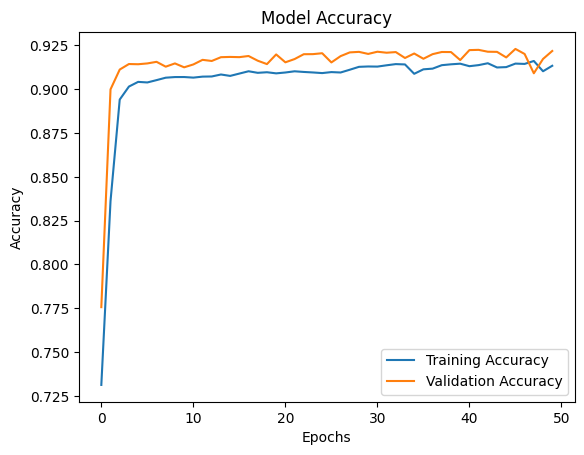

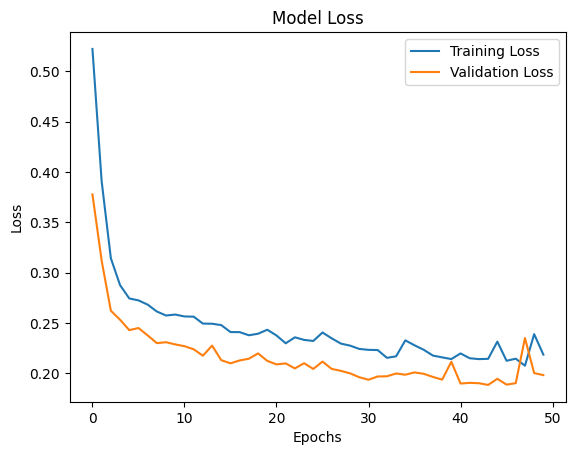

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Visualization of Predictions

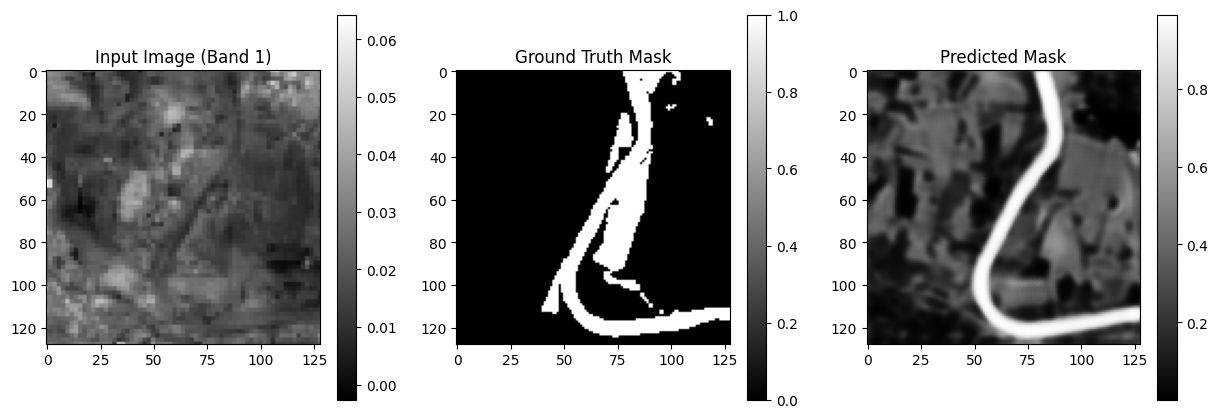

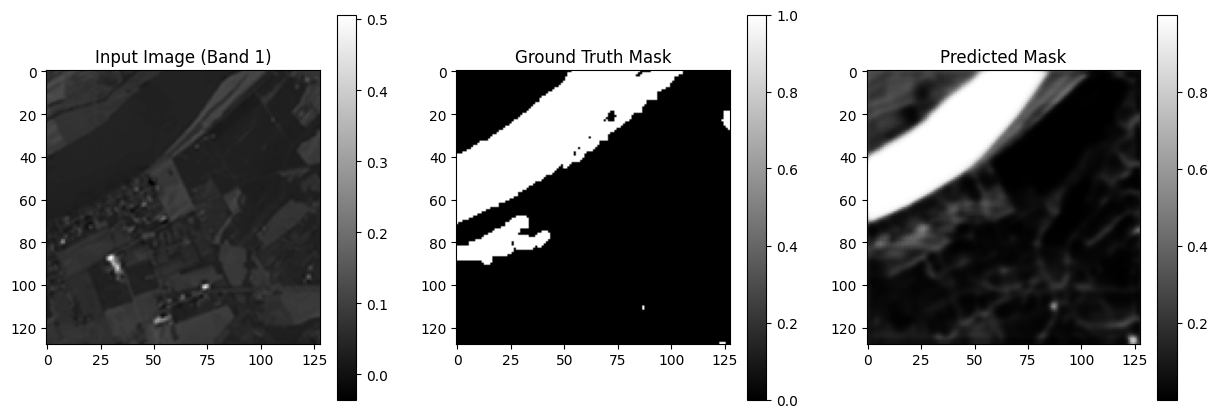

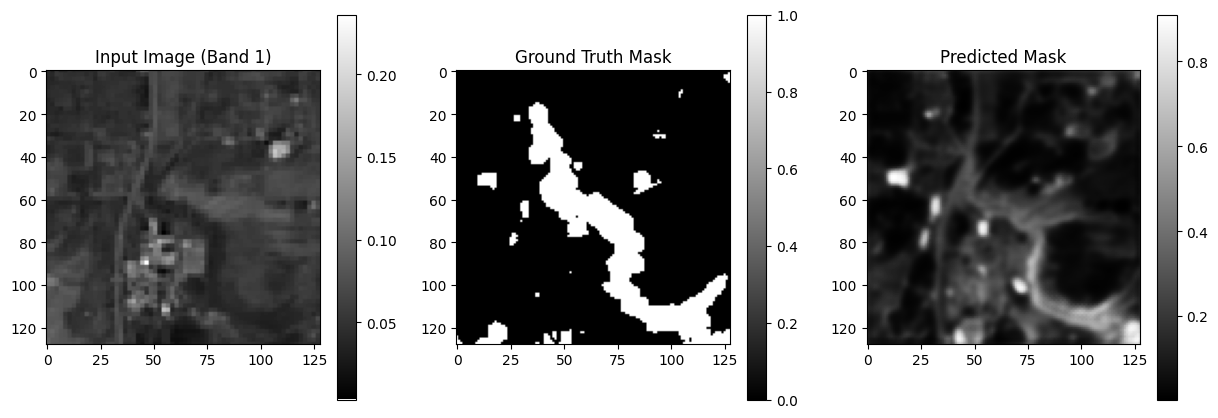

In [16]:
num_visualizations = 3
for i in range(num_visualizations):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Input Image (Band 1)')
    plt.imshow(X_val[i, :, :, 0], cmap='gray')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(Y_val[i, :, :, 0], cmap='gray')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(y_pred[i, :, :, 0], cmap='gray')
    plt.colorbar()

    plt.show()


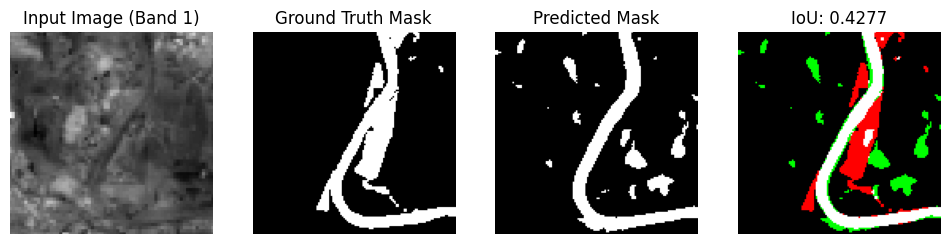

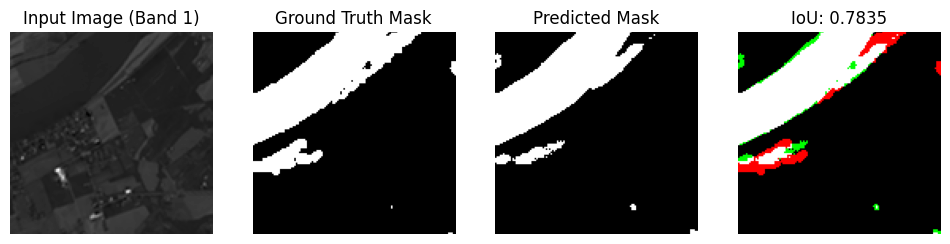

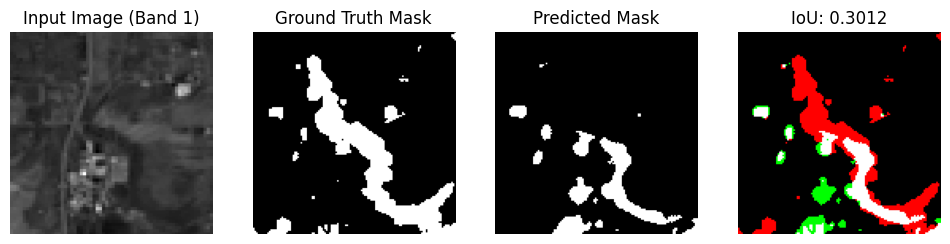

In [18]:
# Function to compute and visualize IoU
def visualize_iou(y_true, y_pred, num_samples=3):
    y_pred = (y_pred > 0.5).astype(np.uint8)  # Convert predictions to binary mask

    for i in range(num_samples):
        gt_mask = y_true[i, :, :, 0]  # Ground Truth
        pred_mask = y_pred[i, :, :, 0]  # Predicted Mask

        # Compute IoU
        intersection = np.logical_and(gt_mask, pred_mask)
        union = np.logical_or(gt_mask, pred_mask)
        iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0

        # Create overlay visualization
        overlay = np.zeros((128, 128, 3))  # RGB Image
        overlay[:, :, 0] = gt_mask  # Ground Truth (Red)
        overlay[:, :, 1] = pred_mask  # Prediction (Green)
        overlay[:, :, 2] = intersection  # TP (Blue)

        # Plot results
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 4, 1)
        plt.title("Input Image (Band 1)")
        plt.imshow(X_val[i, :, :, 0], cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(gt_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title(f"IoU: {iou_score:.4f}")
        plt.imshow(overlay)
        plt.axis('off')

        plt.show()

# Run visualization
visualize_iou(Y_val, y_pred)